# Plot Figures 5-6

These figures show clustering metrics and PCA

For Sawi et al., 2021

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Define helper functions (move later)

In [3]:


def dateToEventID(cat):
    
    evID = []
    
    for i, dt in enumerate(cat.datetime):
        
        a = str(dt)    
        b = a.replace('-','').replace(':','').replace(' ','')[3:]
        
        
        evID.append(b)
        
    cat['event_ID'] = evID
    
    return cat




def getDailyTempDiff2(garciaDF_H,garciaDF_D,**plt_kwargs):

    tstart      =     plt_kwargs['tstartreal']
    tend        =     plt_kwargs['tendreal']

    garciaDF_H1 = garciaDF_H[garciaDF_H.datetime>=tstart]
    garciaDF_H1 = garciaDF_H1[garciaDF_H1.datetime<tend]

    garciaDF_D1 = garciaDF_D[garciaDF_D.datetime>=tstart]
    garciaDF_D1 = garciaDF_D1[garciaDF_D1.datetime<tend]


    temp_H = garciaDF_H1.temp_H.bfill()
    temp_H_a = np.array(temp_H)

    temp_H_a_r = temp_H_a.reshape(len(garciaDF_D1),24)
    mean_diff = []
    for i in range(len(temp_H_a_r[:,0])):
    #     plt.plot(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])
        mean_diff.append(temp_H_a_r[i,:] - garciaDF_D1.temp_D.iloc[i])


    mean_mean_diff = np.mean(mean_diff,axis=0)
    return mean_mean_diff



def catMergeFromH5(path_Cat,path_proj,outfile_name):
    '''
    Keep csv catalog events based on H5 used in SpecUFEx 
    
    '''
    
    ## read 'raw' catalog, the immutable one
    cat_raw = pd.read_csv(path_Cat)
    cat_raw['event_ID'] = [str(int(evv)) for evv in cat_raw['event_ID']]    
    
    
    ## load event IDs from H5
    MLout =  h5py.File(path_proj + outfile_name,'r')
    evID_kept = [evID.decode('utf-8') for evID in MLout['catalog/event_ID/'][:]]
    MLout.close()
    
    ## put H5 events into pandas dataframe
    df_kept = pd.DataFrame({'event_ID':evID_kept})

    ## merge based on event ID
    cat00 = pd.merge(cat_raw,df_kept,on='event_ID')
    
    ## if length of H5 events and merged catalog are equal, then success
    if len(evID_kept) == len(cat00):
        print(f'{len(cat00)} events kept, merge sucessful')
    else:
        print('check merge -- error may have occurred ')
    
    
    ## convert to datetime, set as index
    cat00['datetime'] = [pd.to_datetime(i) for i in cat00.datetime]
    cat00['datetime_index']= [pd.to_datetime(i) for i in cat00.datetime]
    cat00 = cat00.set_index('datetime_index')    


    return cat00
        
        
        

## Set paths

In [4]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathAuxData = '../data/external/GarciaEtAl_2019/processed/'

## Load auxiliary catalog

In [5]:
garciaDF_H = pd.read_csv(f'{pathAuxData}garciaDF_H.csv',index_col=0)
garciaDF_3H = pd.read_csv(f'{pathAuxData}garciaDF_3H.csv',index_col=0)
garciaDF_D = pd.read_csv(f'{pathAuxData}garciaDF_D.csv',index_col=0)


## when loading csv or text, sometimes need to reconvert this column to pandas datetime
garciaDF_H['datetime'] = [pd.to_datetime(ii) for ii in garciaDF_H.index]
garciaDF_3H['datetime'] = [pd.to_datetime(ii) for ii in garciaDF_3H.index]
garciaDF_D['datetime'] = [pd.to_datetime(ii) for ii in garciaDF_D.index]

garciaDF_H['datetime_index'] = [pd.to_datetime(ii) for ii in garciaDF_H.index]
garciaDF_3H['datetime_index'] = [pd.to_datetime(ii) for ii in garciaDF_3H.index]
garciaDF_D['datetime_index'] = [pd.to_datetime(ii) for ii in garciaDF_D.index]


garciaDF_H = garciaDF_H.set_index('datetime_index')
garciaDF_3H = garciaDF_3H.set_index('datetime_index')
garciaDF_D = garciaDF_D.set_index('datetime_index')



garciaDF_D.head(2)

,lake_D,temp_D,rain_D,gps24_D,gps34_D,gps36_D,gps37_D,datetime
datetime_index,,,,,,,,
2007-06-14,25.738000,3.526000,0.500000,0.000000,0.000000,0.000000,0.000000,2007-06-14
2007-06-15,26.140615,7.312125,0.054167,0.033048,0.016641,0.010967,0.012695,2007-06-15


## Define some important times in study period

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [7]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [8]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [9]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [10]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [11]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [12]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [13]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 5 - Reduce dimensionality, visualize PC plots by time, hour

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [14]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762943
3 0.277379352699
4 0.31298114601
5 0.343504119928
6 0.37257466939
7 0.398888188115
8 0.420872255138
9 0.439350890752
10 0.456414864762
11 0.472887558287
12 0.488668811715
13 0.50350831572
14 0.517467859871
15 0.530756524824
16 0.543713467665
17 0.556251688032
18 0.568410385902
19 0.580157595778
20 0.591279469928
21 0.602303139592
22 0.612554046442
23 0.621722869649
24 0.631085214626
25 0.639399142828
26 0.648239450329
27 0.65700423168
28 0.665318178555
29 0.672855248535
30 0.680292950731
31 0.687882673156
32 0.694818529122
33 0.702119506433
34 0.708985375374
35 0.715372476929
36 0.721912263189
37 0.728399697842
38 0.734703988732
39 0.740915265777
40 0.747002190453
41 0.752809425424
42 0.758563723098
43 0.764159806461
44 0.769431811024
45 0.775030729442
46 0.779836002473
47 0.785040346968
48 0.790035596573
49 0.794545731703
50 0.79924424263
51 0.803735635597
52 0.808440523046
53 0.812260196243
54 0.816664192407
55 0.820690049461
56 0.824744072041
57 0.8

In [15]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.31% of variance explained by the first 67 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [16]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## PCA plot colored by datetime

In [17]:
hour_list = [h.hour for h in cat00.datetime]
hour_listN = [h.hour for h in cat00N.datetime]

cat00['hod'] = hour_list
cat00N['hod'] = hour_listN

In [18]:

series_datetime = cat00.datetime
series_datetimeN = cat00N.datetime


series_hour = cat00.hod
series_hourN = cat00N.hod


# Plot Figure 5

** fix colorbars

../src/visualization/figureFunctions2.py:1277: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))
../src/visualization/figureFunctions2.py:1277: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %d'))


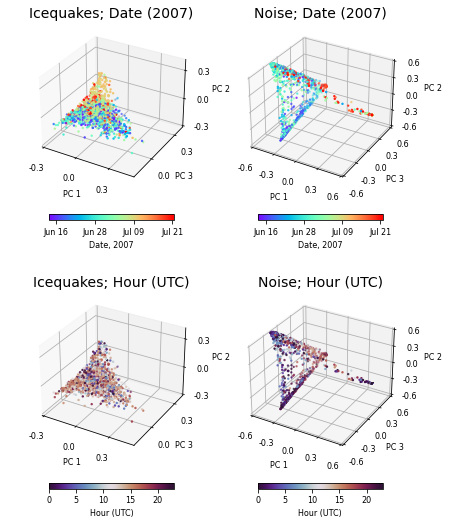

In [19]:
## Plot PCA by datetime, show rep events
tfont=14
catall = catallN = pd.DataFrame({'PC1':[],'PC2':[],'PC3':[],'Cluster':[]})
Kopt=KoptN=1


fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
cmap=cm.get_cmap('rainbow')



ax = fig.add_subplot(221, projection='3d')
figureFunctions2.plotPCA_Stat(cat00, catall, series_datetime, stat_name='Date, 2007', Kopt=Kopt,cmap=cmap, size=2,size2=150, alpha=.15,labelpad=2, fontsize=8,ax=ax, fig=fig,**plt_kwargs)
ax.set_title('Icequakes; Date (2007)',fontsize=tfont)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)


ax = fig.add_subplot(222, projection='3d')
figureFunctions2.plotPCA_Stat(cat00N, catallN, series_datetimeN, stat_name='Date, 2007', Kopt=KoptN,cmap=cmap, size=2,size2=150, alpha=.15,labelpad=4, fontsize=8,ax=ax, fig=fig,**plt_kwargs)
ax.set_title('Noise; Date (2007)',fontsize=tfont)


cmap=cm.get_cmap('twilight_shifted')
ax = fig.add_subplot(223, projection='3d')
figureFunctions2.plotPCA_Stat(cat00, catall, series_hour, stat_name='Hour (UTC)', Kopt=Kopt,cmap=cmap, size=2,size2=150, alpha=.15,labelpad=2, fontsize=8,ax=ax, fig=fig,**plt_kwargs)
ax.set_title('Icequakes; Hour (UTC)',fontsize=tfont)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)


ax = fig.add_subplot(224, projection='3d')
figureFunctions2.plotPCA_Stat(cat00N, catallN, series_hourN, stat_name='Hour (UTC)', Kopt=KoptN,cmap=cmap, size=2,size2=150, alpha=.15,labelpad=4, fontsize=8,ax=ax, fig=fig,**plt_kwargs)
# ax.set_title('Noise',fontsize=tfont)
ax.set_title('Noise; Hour (UTC)',fontsize=tfont)
plt.subplots_adjust(wspace=0,hspace=0.2)


plt.savefig(pathFig + 'Figure_5.png')

# Figure 6 - clustering results [using mean silh score, not median -- outliers should influence clustering]

## Clustering using Kmeans, validating using silhouette score

In [20]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


## Plot PCA with 10 most representative events

In [21]:
catRep = getTopFCat(cat00,topF=10) 

catRepN = getTopFCat(cat00N,topF=10)

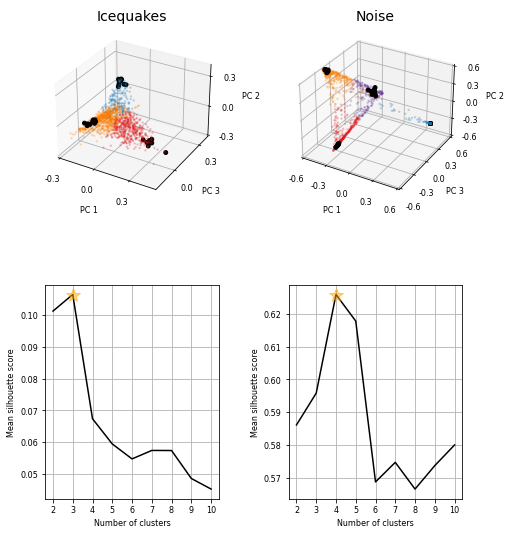

In [30]:
fig,axes = plt.subplots(figsize = (width2,height2))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])

size_dot = 2
alpha_dot = .2

size_rep = 15

ax = fig.add_subplot(221, projection='3d')
ax.set_title('Icequakes',fontsize=tfont)
figureFunctions2.plotPCA(cat00,catRep,Kopt, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=8,ax=ax, fig=fig, **plt_kwargs)
ax.set_xlim(-.3,.5)
ax.set_ylim(-.2,.4)    
ax.set_zlim(-.3,.4)

plt.subplots_adjust(wspace=0.1,hspace=0.2)


ax = fig.add_subplot(222, projection='3d')
ax.set_title('Noise',fontsize=tfont)
figureFunctions2.plotPCA(cat00N,catRepN,KoptN, size=size_dot,size2=size_rep, alpha=alpha_dot,labelpad = 5,fontsize=8,ax=ax, fig=fig, **plt_kwargs)



ax = fig.add_subplot(223)
figureFunctions2.plotSilhScore(Kopt, avgSils, range_n_clusters_all,starSize=15,ax=ax)

ax = fig.add_subplot(224)
figureFunctions2.plotSilhScore(KoptN, avgSilsN, range_n_clusters_all,starSize=15,ax=ax)

plt.subplots_adjust(wspace=0.4,hspace=0.3)

plt.savefig(pathFig + f'Figure_6.pdf',bbox_inches='tight')


# Figure 7 - rep events

1
2
3
4


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


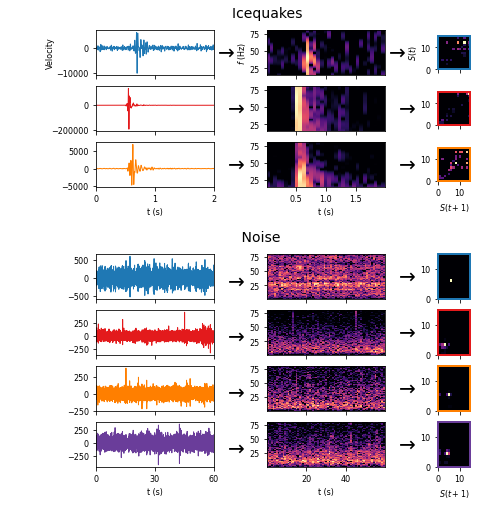

In [31]:
plt.rcParams.update({'font.size': 8})

count =0
tpad=13

bW = 2#spine bar width
bA = 1
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)


gs = gridspec.GridSpec(len(catallN)+len(catall)+2, 10)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.3, hspace=.25)



for i, evID in enumerate(catall.event_ID):
    
    
    k = int(catall.Cluster.iloc[i])
    
    
    
    ##plot wf
    ax=plt.subplot(gs[i,0:3])
    wf_zeromean = figureFunctions2.plotWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs,tSTFT,colorBy='cluster',k=k,ax=ax,**plt_kwargs)


    if k == 1:
        ax.set_ylabel('Velocity',labelpad=1)
        ax.set_title('                                                  Icequakes',fontsize=tfont,pad=tpad)   

    else:
        ax.set_title('')
        ax.set_ylabel('')
        
    if k ==Kopt:    
        ax.set_xlabel('t (s)',labelpad=4)   
        
    else:
        ax.set_xlabel('')
        ax.set_xlabel('')
        ax.set_xticklabels('')
    
    
    
    ##plot arrow00
    ax=plt.subplot(gs[i,3])

    if k==1:

        ax.text(-.3,.4,r'$\rightarrow$',fontsize=20)
        
    else:
        ax.text(0,.4,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
      
        
        
#     plot sgram:
    ax = plt.subplot(gs[i,4:7])


    specMat,x = getSgram(path_proj,str(evID),station)
    figureFunctions2.plotSgram(specMat,str(evID),tSTFT,fSTFT,ax=ax)
#     figureFunctions2.plotSpines(cat=catall,k=k,axs=ax,barWidth=bW,alphaBar=bA,**plt_kwargs)

    ax.set_title('')

    
    if i ==0:    
        ax.set_ylabel('$f$ (Hz)',labelpad=1)

    else:
        ax.set_title('')
        ax.set_ylabel('')
        
    if i ==len(catall.event_ID)-1:    
        ax.set_xlabel('t (s)',labelpad=4)   
    else:
        ax.set_xlabel('')
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
    ##plot arrow1
    ax = plt.subplot(gs[i,7:8])
    if k ==1:

        ax.text(-.3,.4,r'$\rightarrow$',fontsize=20)
        
    else:
        ax.text(0,.4,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
      
    
    ### plot FP
    ax=plt.subplot(gs[i,8:9])    
    figureFunctions2.plotSpines(cat=catall,k=k,axs=ax,barWidth=bW,alphaBar=bA,**plt_kwargs)
    figureFunctions2.plotFP(path_proj,outfile_name,evID,ax=ax)
    ax.set_aspect('equal')

    if k == 1:
        ax.set_ylabel('$S(t)$',labelpad=1)
    else:
        ax.set_ylabel('')
        ax.set_aspect('equal')
    if k == Kopt:    
        ax.set_xlabel('$S(t+1)$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
        
        

##############################
##### NOISENOISENOISENOISE
##############################



for i, evID in enumerate(catallN.event_ID):
    
    k = int(catallN.Cluster.iloc[i])
    print(k)
    i = i + Kopt + 1
    ##plot wf
    ax=plt.subplot(gs[i,0:3])
    wf_data = figureFunctions2.plotWF(str(evID),dataH5_pathN,station,channel,fminN,fmaxN,fs,tSTFTN,colorBy='cluster',k=k,ax=ax,**plt_kwargs)

    ax.set_ylabel('')        

    if k ==1:    
        ax.set_title('                                               Noise',fontsize=tfont,pad=tpad)   
#         ax.set_ylabel('Velocity',labelpad=1)

    else:
        ax.set_title('')
        ax.set_ylabel('')
#         ax.set_yticklabels('')        

        
    if k ==KoptN:
        ax.set_xlabel('t (s)',labelpad=4)   
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
    
    
    
    ##plot arrow1
    ax = plt.subplot(gs[i,3:4])
    ax.text(0,.3,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
    
    
    
    
    
    
    ##plot sgram

    ax=plt.subplot(gs[i,4:7])
    specMat,x = getSgram(path_projN,str(evID),station)
    figureFunctions2.plotSgram(specMat,str(evID),tSTFTN,fSTFTN,ax=ax)
#     figureFunctions2.plotSpines(cat=catall,k=k,axs=ax,barWidth=bW,alphaBar=1, **plt_kwargs)

    ax.set_title('')
    ax.set_ylabel('')
#     ax.set_yticklabels('')        
        

    if k ==KoptN:    
        ax.set_xlabel('t (s)',labelpad=4)   
    else:
        ax.set_xlabel('')
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
#     ##plot arrow2
    ax = plt.subplot(gs[i,7:8])
    ax.text(0,.4,r'$\rightarrow$',fontsize=20)        
    ax.axis('off')
  
    
    ### plot FP
    ax=plt.subplot(gs[i,8:9]) 
    figureFunctions2.plotSpines(cat=catallN,k=k,axs=ax,barWidth=bW,alphaBar=bA,**plt_kwargs)
    figureFunctions2.plotFP(path_projN,outfile_nameN,evID,ax=ax)


    ax.set_ylabel('')
#     ax.set_aspect('equal')
    
    
    if k ==KoptN:    
        ax.set_xlabel('$S(t+1)$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        


    
plt.tight_layout()
plt.savefig(pathFig + f'Figure_7.pdf',bbox_inches='tight')

In [ ]:



## move to analysis
# clus_sel = [1,2,3]
# sel_state = [12,14,8]

# clus_selN = [1,2,3,4]
# sel_stateN = [6,3,5,4]

# leg = ['During/after flood','Before flood','PM']
# legN = ['During/after flood','Before flood','Rain?','PM']

# ## move to clustering
# mode = 'fingerprints'#'kernalPCA'#'fingerprints'#'PCA' 

# print(key,mode,Kopt, ' clusters')
